In [1]:
!git init
!git remote add origin https://github.com/sgerloff/sustainable_deepfashion.git
!git pull origin main

!pip install -r requirements.txt

!make setup-preprocessed-gc CATEGORY_ID=1 MIN_PAIR_COUNT=20

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (548/548), done.
remote: Compressing objects: 100% (373/373), done.
remote: Total 548 (delta 311), reused 364 (delta 153), pack-reused 0
Receiving objects: 100% (548/548), 4.43 MiB | 10.84 MiB/s, done.
Resolving deltas: 100% (311/311), done.
From https://github.com/sgerloff/sustainable_deepfashion
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main
     |████████████████████████████████| 706kB 10.4MB/s 
  Created wheel for zipfile38: filename=zipfile38-0.0.3-cp37-none-any.whl size=22765 sha256=f399a4a455dff9c29cc04bf4ba6efb0dfe10d036cbfb741f9028f1d12a1fe271
  Stored in directory: /root/.cache/pip/wheels/15/7a/ec/508d28bf3894e050aef4d0205cdf27a346e6e0891e979345d4
Successfully built zipfile38


Streaming output truncated to the last 5000 lines.
  inflating: data/processed/train/cat1/107930_8543.jpg  
  inflating: data/processed/train/cat1/024331_1934.jpg  
  inflating: data/processed/train/cat1/141052_11086.jpg  
  inflating: data/processed/train/cat1/182857_14346.jpg  
  inflating: data/processed/train/cat1/010400_837.jpg  
  inflating: data/processed/train/cat1/094388_7451.jpg  
  inflating: data/processed/train/cat1/061448_4860.jpg  
  inflating: data/processed/train/cat1/004991_398.jpg  
  inflating: data/processed/train/cat1/159042_12457.jpg  
  inflating: data/processed/train/cat1/154596_12114.jpg  
  inflating: data/processed/train/cat1/168740_13223.jpg  
  inflating: data/processed/train/cat1/074348_5870.jpg  
  inflating: data/processed/train/cat1/097553_7718.jpg  
  inflating: data/processed/train/cat1/069704_5520.jpg  
  inflating: data/processed/train/cat1/171464_13426.jpg  
  inflating: data/processed/train/cat1/180180_14119.jpg  
  inflating: data/processed/trai

# Download the model that you want to check:

In [2]:
!wget http://d2fcl18pl6lkip.cloudfront.net/simple_conv2d_embedding_size_32.zip
!unzip simple_conv2d_embedding_size_32.zip

--2021-03-18 15:10:56--  http://d2fcl18pl6lkip.cloudfront.net/simple_conv2d_embedding_size_32.zip
Resolving d2fcl18pl6lkip.cloudfront.net (d2fcl18pl6lkip.cloudfront.net)... 13.226.211.231, 13.226.211.200, 13.226.211.86, ...
Connecting to d2fcl18pl6lkip.cloudfront.net (d2fcl18pl6lkip.cloudfront.net)|13.226.211.231|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://d2fcl18pl6lkip.cloudfront.net/simple_conv2d_embedding_size_32.zip [following]
--2021-03-18 15:10:56--  https://d2fcl18pl6lkip.cloudfront.net/simple_conv2d_embedding_size_32.zip
Connecting to d2fcl18pl6lkip.cloudfront.net (d2fcl18pl6lkip.cloudfront.net)|13.226.211.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5712727 (5.4M) [application/zip]
Saving to: ‘simple_conv2d_embedding_size_32.zip’

simple_conv2d_embed 100%[===================>]   5.45M  4.67MB/s    in 1.2s    

2021-03-18 15:10:58 (4.67 MB/s) - ‘simple_conv2d_embedding_size_32.zip’ saved [57

# Load model, dataset and more from the metadata file:

In [18]:
from src.instruction_utility import *
from src.data.flat_dataset_factory import FlatDatasetFactory

import numpy as np

The metadata file accompanies the saved weights of a model and includes instructions how to build and compile the model. But where to find validation data and how to load it.

In [8]:
metadata_file = "simple_conv2d_embedding_size_32.meta"
metadata = load_metadata(metadata_file)
ip = InstructionParser(metadata["instruction"], is_dict=True)
model = load_model_from_metadata(metadata_file)

In [9]:
path_to_df = metadata["instruction"]["validation_data"]["dataframe"]
validation_dataframe = load_dataframe(path_to_df)
factory = FlatDatasetFactory(validation_dataframe, preprocessor=ip.model_factory.preprocessor())
dataset = factory.get_dataset()

# Do some predictions:

In [21]:
pred = model.predict(dataset)
true_labels = np.concatenate([y for x,y in dataset], axis=0)

In [22]:
pred.shape, true_labels.shape

((4074, 32), (4074,))

In [28]:
filled_true_labels = np.broadcast_to(true_labels, shape=(true_labels.shape[0],true_labels.shape[0]))
match_pair_id_map = (filled_true_labels == filled_true_labels.T)

In [29]:
match_pair_id_map

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [39]:
filled_pred = np.broadcast_to(pred, shape=(pred.shape[0], pred.shape[0], pred.shape[1]))
pred_differences = np.linalg.norm(filled_pred - np.transpose(filled_pred, axes=[1,0,2]), axis=2)

In [43]:
tmp = [ (i, filled_true_labels[0][i], pred_differences[0][i]) for i in range(pred_differences.shape[0])]

In [61]:
import matplotlib.pyplot as plt

In [62]:
def show_top_20_predictions_for_index(index, k=20):
  triplets = [ (i, filled_true_labels[index][i], pred_differences[index][i]) for i in range(pred_differences[index].shape[0])]
  sorted_pred = sorted(triplets, key=lambda triplet: triplet[2])[:20]
  sorted_index = [v[0] for v in sorted_pred ]

  pred_df = validation_dataframe.iloc[sorted_index]
  pred_factory = FlatDatasetFactory(pred_df, preprocessor=ip.model_factory.preprocessor())
  pred_dataset = pred_factory.get_dataset(batch_size=20)

  plt.figure(figsize=(20,16))
  for X,y in pred_dataset.take(1):
    for i in range(X.shape[0]):
      plt.subplot(5,4,i+1)
      plt.imshow(X[i]/255)
      plt.axis("off")
      plt.title(f"pair_id = {int(y[i])}")
    plt.show()

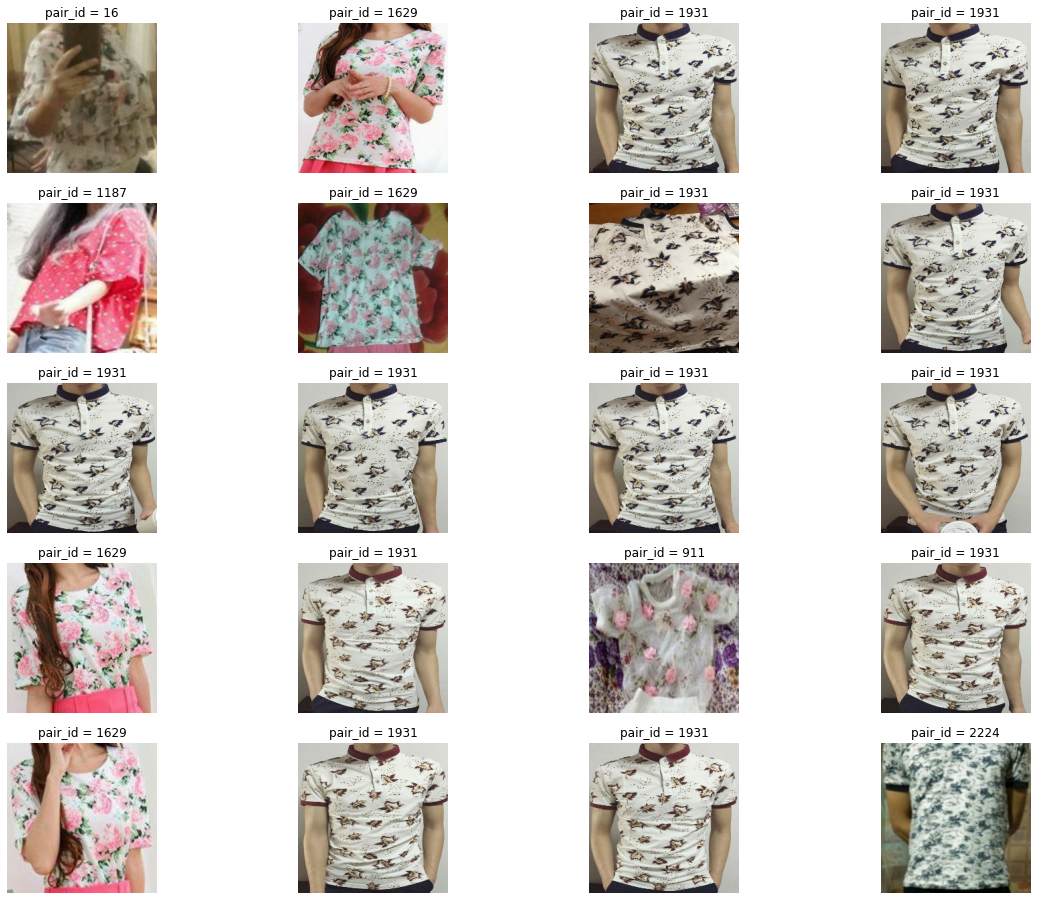

In [69]:
show_top_20_predictions_for_index(1)